In [101]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import matplotlib.pyplot as plt

BoxSize = 25.0
redshift_044 = 2.0
little_h =  0.6711

#snaps available:
#snap_044, z=2.00 = 2
#snap_052, z=1.48 = 1.5
#snap_060, z=1.05 = 1
#snap_086, z=0.10 = 0.1


# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

massBinLimits = np.arange(-24, -16, 0.5)


In [102]:
# first things first, lets just read in the hdf5 files to see what they look like.
file_path = "/disk/xray15/aem2/data/28pams/IllTNG/IllustrisTNG_1P_p28_n1_photometry.hdf5"
with h5py.File(file_path, 'r') as f:
    
    # Function to recursively print the structure of the HDF5 file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Data Type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
            
    # Use the visititems method to iterate over all groups and datasets in the file
    f.visititems(print_structure)

Group: snap_044
Group: snap_044/BC03
Group: snap_044/BC03/photometry
Group: snap_044/BC03/photometry/flux
Group: snap_044/BC03/photometry/flux/attenuated
Dataset: snap_044/BC03/photometry/flux/attenuated/GALEX FUV, Shape: (931,), Data Type: float64
Dataset: snap_044/BC03/photometry/flux/attenuated/GALEX NUV, Shape: (931,), Data Type: float64
Group: snap_044/BC03/photometry/flux/attenuated/Generic
Dataset: snap_044/BC03/photometry/flux/attenuated/Generic/Johnson.B, Shape: (931,), Data Type: float64
Dataset: snap_044/BC03/photometry/flux/attenuated/Generic/Johnson.J, Shape: (931,), Data Type: float64
Dataset: snap_044/BC03/photometry/flux/attenuated/Generic/Johnson.U, Shape: (931,), Data Type: float64
Dataset: snap_044/BC03/photometry/flux/attenuated/Generic/Johnson.V, Shape: (931,), Data Type: float64
Group: snap_044/BC03/photometry/flux/attenuated/HST
Dataset: snap_044/BC03/photometry/flux/attenuated/HST/ACS_HRC.F435W, Shape: (931,), Data Type: float64
Dataset: snap_044/BC03/photometry

In [103]:
import h5py

# Open the HDF5 file in read-only mode
file_path = "/disk/xray15/aem2/data/28pams/IllTNG/IllustrisTNG_1P_p16_n1_photometry.hdf5"
with h5py.File(file_path, 'r') as f:
    
    # Recursive function to print structure with indentation for different levels
    def print_structure(name, obj, level=0):
        indent = "  " * level
        if isinstance(obj, h5py.Group):
            print(f"{indent}Group: {name}")
            for key, item in obj.items():
                print_structure(key, item, level + 1)
        elif isinstance(obj, h5py.Dataset):
            print(f"{indent}Dataset: {name}, Shape: {obj.shape}, Data Type: {obj.dtype}")

    # Start with the root group
    print("HDF5 File Structure:")
    print_structure('/', f)


HDF5 File Structure:
Group: /
  Group: snap_044
    Group: BC03
      Group: photometry
        Group: flux
          Group: attenuated
            Dataset: GALEX FUV, Shape: (867,), Data Type: float64
            Dataset: GALEX NUV, Shape: (867,), Data Type: float64
            Group: Generic
              Dataset: Johnson.B, Shape: (867,), Data Type: float64
              Dataset: Johnson.J, Shape: (867,), Data Type: float64
              Dataset: Johnson.U, Shape: (867,), Data Type: float64
              Dataset: Johnson.V, Shape: (867,), Data Type: float64
            Group: HST
              Dataset: ACS_HRC.F435W, Shape: (867,), Data Type: float64
              Dataset: ACS_HRC.F606W, Shape: (867,), Data Type: float64
              Dataset: ACS_HRC.F775W, Shape: (867,), Data Type: float64
              Dataset: ACS_HRC.F814W, Shape: (867,), Data Type: float64
              Dataset: ACS_HRC.F850LP, Shape: (867,), Data Type: float64
              Dataset: WFC3_IR.F098M, Shape: (867

In [104]:
import h5py

# Open the HDF5 file in read-only mode
file_path = "/disk/xray15/aem2/data/28pams/IllTNG/IllustrisTNG_1P_p16_n1_photometry.hdf5"
with h5py.File(file_path, 'r') as hdf:
    lum_UV1500 = hdf['/snap_044/BC03/photometry/luminosity/intrinsic/UV1500'][:]

    # unit error so add units again?
    lum_UV1500_unyt = lum_UV1500 * erg / (Hz * s)

    abs_mags = [lnu_to_absolute_mag(lum_UV1500_unyt)]
    abs_mag_th = abs_mags[0]
    # next steps, get luminosity function for these magnitudes
    # co-moving volume: BoxSize_025 and redshift:
    Vphys = (BoxSize/little_h )**3
    Vcom = Vphys * ((1+redshift_044)**3)
    print(Vcom)

    phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

    df = pd.DataFrame({
        'phi': phi,
        'phi_sigma': phi_sigma,
        'hist': hist
    })
    df['AGN1']= 0.25

    print(df)

1395796.3995351559
         phi  phi_sigma  hist  AGN1
0   0.000000   0.000000   0.0  0.25
1   0.000000   0.000000   0.0  0.25
2   0.000001   0.000001   1.0  0.25
3   0.000010   0.000004   7.0  0.25
4   0.000016   0.000005  11.0  0.25
5   0.000029   0.000006  20.0  0.25
6   0.000026   0.000006  18.0  0.25
7   0.000060   0.000009  42.0  0.25
8   0.000047   0.000008  33.0  0.25
9   0.000056   0.000009  39.0  0.25
10  0.000069   0.000010  48.0  0.25
11  0.000063   0.000010  44.0  0.25
12  0.000077   0.000011  54.0  0.25
13  0.000080   0.000011  56.0  0.25
14  0.000080   0.000011  56.0  0.25


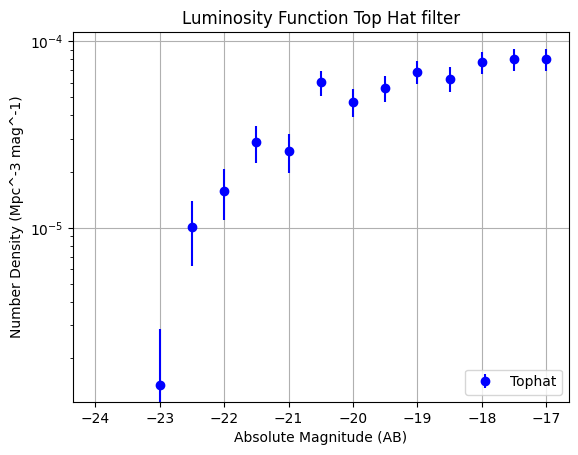

In [105]:
label_025 = 'z = ', redshift_044
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()